### Import Libraries

In [144]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import os
from torchvision import transforms
import torch.optim as optim
import cv2
import math
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Autoencoder training process

Data loading

In [166]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset

class AutoencoderDataset(Dataset):
    def __init__(self, root_dir, image_type1="img2.png", image_type2="corner2.png", transform=None):
        """
        root_dir: path to dataset (e.g., "synthetic_dataset_complex")
        image_type1: input image name (e.g., "img1.png")
        image_type2: target image name (e.g., "ellipse1.png")
        transform: optional transform function (should operate on tensors or arrays)
        """
        self.root_dir = root_dir
        self.sample_dirs = sorted([
            os.path.join(root_dir, d) for d in os.listdir(root_dir)
            if os.path.isdir(os.path.join(root_dir, d))
        ])
        self.image_type1 = image_type1
        self.image_type2 = image_type2
        self.transform = transform

    def __len__(self):
        return len(self.sample_dirs)

    def __getitem__(self, idx):
        sample_path = self.sample_dirs[idx]

        input_path = os.path.join(sample_path, self.image_type1)
        target_path = os.path.join(sample_path, self.image_type2)

        # Load input and target images, normalize
        input_img = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
        target_img = cv2.imread(target_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0

        input_img = np.expand_dims(input_img, axis=0)   # Shape: (1, H, W)
        target_img = np.expand_dims(target_img, axis=0) # Shape: (1, H, W)

        if self.transform:
            input_img = self.transform(input_img)
            target_img = self.transform(target_img)

        return torch.tensor(input_img), torch.tensor(target_img)


In [167]:
root_dir = "synthetic_dataset_complex"

dataset = AutoencoderDataset(root_dir)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)

Define model

In [147]:
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # --- Encoder ---
        self.enc1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=4, stride=2, padding=1),  # (B, 16, 128, 128)
            nn.ReLU()
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1),  # (B, 32, 64, 64)
            nn.ReLU()
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # (B, 64, 32, 32)
            nn.ReLU()
        )

        # --- Decoder ---
        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # (B, 32, 64, 64)
            nn.ReLU()
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(64, 16, kernel_size=4, stride=2, padding=1),  # (B, 16, 128, 128)
            nn.ReLU()
        )
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),   # (B, 1, 256, 256)
            nn.Sigmoid()  # for binary mask reconstruction
        )

    def forward(self, x):
        # --- Encoding ---
        x1 = self.enc1(x)  # (B, 16, 128, 128)
        x2 = self.enc2(x1) # (B, 32, 64, 64)
        x3 = self.enc3(x2) # (B, 64, 32, 32)

        # --- Decoding ---
        d3 = self.dec3(x3)           # (B, 32, 64, 64)
        d3 = torch.cat([d3, x2], 1)  # (B, 64, 64, 64)

        d2 = self.dec2(d3)           # (B, 16, 128, 128)
        d2 = torch.cat([d2, x1], 1)  # (B, 32, 128, 128)

        out = self.dec1(d2)          # (B, 1, 256, 256)
        return out


Create model, loss function and optimizer

In [148]:
batch_size = 16
num_epochs = 35
learning_rate = 1e-3

model = Autoencoder().to(device)
criterion = nn.BCELoss()  # Since we use sigmoid in output
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Auto-encoder training loop

In [169]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for inputs, targets in progress_bar:
        inputs = inputs.to(device)    # (B, 1, 256, 256)
        targets = targets.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs} - Avg Loss: {avg_loss:.6f}")


Epoch 1/35 - Avg Loss: 0.006352


Epoch 2/35 - Avg Loss: 0.006138


Epoch 3/35 - Avg Loss: 0.006001


Epoch 4/35 - Avg Loss: 0.005878


Epoch 5/35 - Avg Loss: 0.005853


Epoch 6/35 - Avg Loss: 0.005821


Epoch 7/35 - Avg Loss: 0.005798


Epoch 8/35 - Avg Loss: 0.005749


Epoch 9/35 - Avg Loss: 0.005665


Epoch 10/35 - Avg Loss: 0.005662


Epoch 11/35 - Avg Loss: 0.005624


Epoch 12/35 - Avg Loss: 0.005627


Epoch 13/35 - Avg Loss: 0.005651


Epoch 14/35 - Avg Loss: 0.005512


Epoch 15/35 - Avg Loss: 0.005546


Epoch 16/35 - Avg Loss: 0.005566


Epoch 17/35 - Avg Loss: 0.005508


Epoch 18/35 - Avg Loss: 0.005415


Epoch 19/35 - Avg Loss: 0.005440


Epoch 20/35 - Avg Loss: 0.005409


Epoch 21/35 - Avg Loss: 0.005461


Epoch 22/35 - Avg Loss: 0.005411


Epoch 23/35 - Avg Loss: 0.005349


Epoch 24/35 - Avg Loss: 0.005310


Epoch 25/35 - Avg Loss: 0.005266


Epoch 26/35 - Avg Loss: 0.005367


Epoch 27/35 - Avg Loss: 0.005260


Epoch 28/35 - Avg Loss: 0.005209


Epoch 29/35 - Avg Loss: 0.005290


Epoch 30/35 - Avg Loss: 0.005363


Epoch 31/35 - Avg Loss: 0.005242


Epoch 32/35 - Avg Loss: 0.005245


Epoch 33/35 - Avg Loss: 0.005228


Epoch 34/35 - Avg Loss: 0.005140


Epoch 35/35 - Avg Loss: 0.005130


In [165]:
# Save the autoencoder model as a checkpoint
checkpoint_path = "autoencoder_checkpoint.pth"
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': avg_loss,
}, checkpoint_path)
print(f"Model checkpoint saved to {checkpoint_path}")

Model checkpoint saved to autoencoder_checkpoint.pth


See results of trained auto encoder

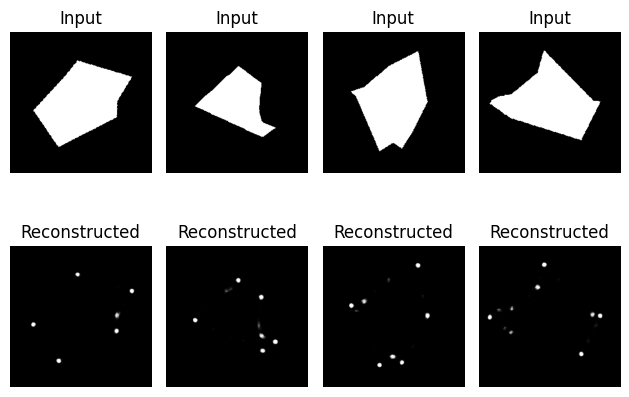

In [170]:
model.eval()
with torch.no_grad():
    for inputs, _ in train_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        break  # only one batch

# Show first 4 reconstructions
for i in range(4):
    inp = inputs[i].cpu().squeeze().numpy()
    out = outputs[i].cpu().squeeze().numpy()
    
    plt.subplot(2, 4, i+1)
    plt.imshow(inp, cmap="gray")
    plt.title("Input")
    plt.axis("off")
    
    plt.subplot(2, 4, i+5)
    plt.imshow(out, cmap="gray")
    plt.title("Reconstructed")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [183]:
def extract_coordinates_from_heatmap(heatmap_tensor, threshold=0.5, center=None, degrees=True):
    heatmap = heatmap_tensor.squeeze().cpu().numpy()  # (H, W)
    H, W = heatmap.shape
    binary = (heatmap > threshold).astype(np.uint8)

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary, connectivity=8)

    if center is None:
        center = (W // 2, H // 2)

    cx, cy = center
    polar_coords = []

    for i in range(1, num_labels):  # skip background
        x, y = centroids[i]
        dx, dy = x - cx, y - cy
        radius = np.sqrt(dx**2 + dy**2)
        angle = np.arctan2(dy, dx)
        if degrees:
            angle = np.degrees(angle) % 360
        polar_coords.append((radius, angle))

    # Sort by radius (distance from center)
    polar_coords.sort(key=lambda x: x[0])

    return polar_coords

Detected corners: [(np.float64(62.99269899563113), np.float64(286.88646044673004)), (np.float64(63.30219595166475), np.float64(323.28627928730333)), (np.float64(77.1679577849796), np.float64(283.8256430533655)), (np.float64(80.2755842176661), np.float64(296.31840082638814)), (np.float64(84.02442303769521), np.float64(73.52449027037328)), (np.float64(84.29373989677657), np.float64(187.6003774382115)), (np.float64(89.66894547960054), np.float64(332.0701884190863)), (np.float64(93.38999196473654), np.float64(170.43223258765158))]


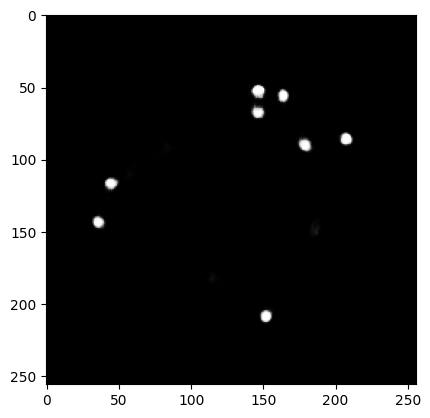

In [205]:
def predict_image(image_path):
    # Load and preprocess image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=0)  # (1, H, W)
    img = np.expand_dims(img, axis=0)  # (1, 1, H, W)
    img_tensor = torch.tensor(img).to(device)

    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        heatmap = output[0]  # (1, H, W)
        corner_coords = extract_coordinates_from_heatmap(heatmap, threshold=0.5)
        print("Detected corners:", corner_coords)

    output_img = output.cpu().squeeze().numpy()
    return output_img

# Example usage:
result_img = predict_image("synthetic_dataset_complex\sample_0000\img2.png")
plt.imshow(result_img, cmap="gray")
plt.show()